<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#вывод-по-главе-'Подготовка-двнных':" data-toc-modified-id="вывод-по-главе-'Подготовка-двнных':-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>вывод по главе 'Подготовка двнных':</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#вывод-по-главе-'Анализ-двнных':" data-toc-modified-id="вывод-по-главе-'Анализ-двнных':-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>вывод по главе 'Анализ двнных':</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#вывод-по-главе-'Обучение-моделей':" data-toc-modified-id="вывод-по-главе-'Обучение-моделей':-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>вывод по главе 'Обучение моделей':</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV,TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,make_scorer

from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from catboost import  Pool

import warnings
warnings.filterwarnings("ignore")

SEED = np.random.RandomState(0)

## Подготовка

In [2]:
df= pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

<div style="padding: 30px 25px; border: 5px #9966FF solid">
    
### вывод по главе 'Подготовка двнных':
    
- имрортировали библеотеки 
- загрузили данные 
- сделали ресемплирование

## Анализ

In [4]:
def data_analis (df):
    i=df.info()
    h=df.head()
    ds=df.describe()
    dp=df.duplicated().sum()
    isna = df.isna().sum()
    return print(i),display(h), display(ds), print('дубликаты:',dp), print('пропуски:', isna,sep=' ')

In [5]:
data_analis(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


дубликаты: 4165
пропуски: num_orders    0
dtype: int64


(None, None, None, None, None)

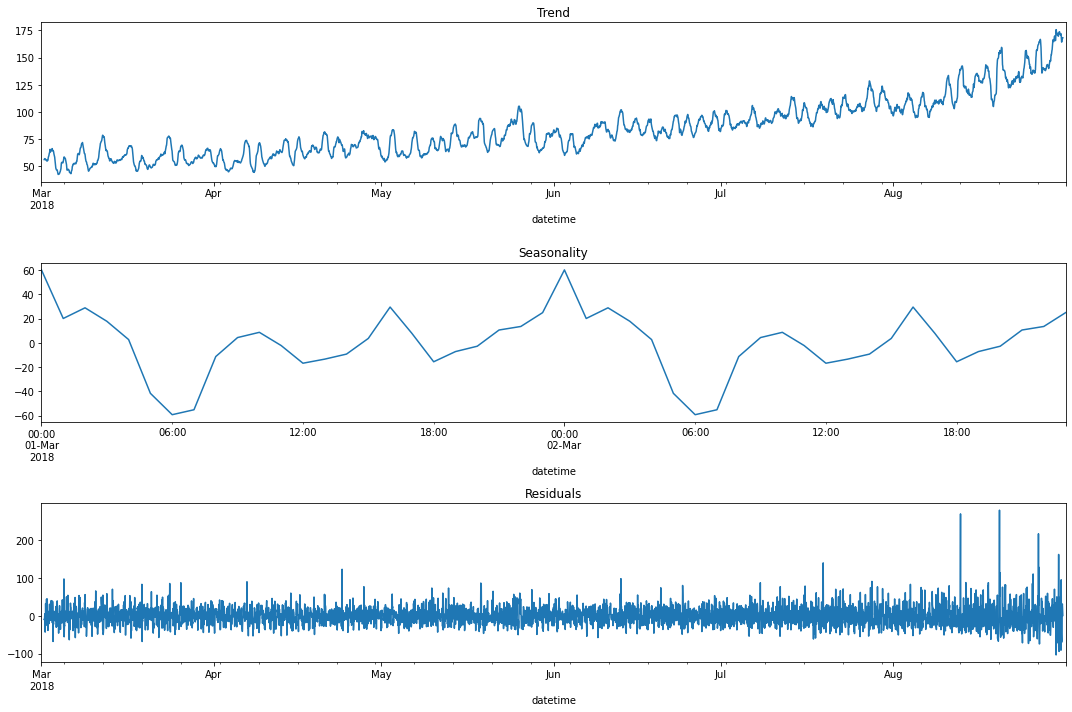

In [6]:
decomposed =seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01': '2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div style="padding: 30px 25px; border: 5px #9966FF solid">
    
### вывод по главе 'Анализ двнных':
    
- посмотрели на данные
- построили график временого ряда
- на грфике виден Стохастический процесс т.е. количество водителей по месяцам равномерно распределено


## Обучение

In [1]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(fill_value=0).rolling(rolling_mean_size).mean()


make_features(df, 60, 24)

NameError: name 'df' is not defined

In [8]:
features = df.copy().drop('num_orders', axis=1)
target = df['num_orders']

In [9]:
features= features.fillna(features.mean())

<AxesSubplot:xlabel='num_orders', ylabel='Count'>

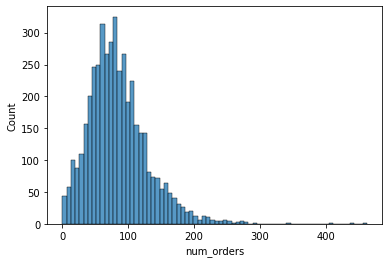

In [10]:
sns.histplot(target)

имеем относительно однородные данные

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=.1, shuffle=False, 
                                                                            random_state=SEED)
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                            test_size=.5, shuffle=False, 
                                                                            random_state=SEED)

In [12]:
lr=LinearRegression()
lr_model=lr.fit(features_train,target_train)
pred_train=lr_model.predict(features_train)
pred_valid=lr_model.predict(features_valid)

print("RMSE обучающей выборки:", np.sqrt(mean_squared_error(target_train,pred_train)))
print("RMSE тестовой выборки:", np.sqrt(mean_squared_error(target_valid,pred_valid)))

RMSE обучающей выборки: 20.48961357883116
RMSE тестовой выборки: 31.907876444415546


In [13]:
param_grid= {
    'max_depth': range(1,50,5),
    'min_samples_split': range(2,100,2),
    'min_samples_leaf' : [2,5,10]
}

dt= DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=3)
scorer= make_scorer(mean_squared_error)
r_s_dt= RandomizedSearchCV(estimator=dt,
                                      param_distributions=param_grid,
                                      cv=tscv,
                                      verbose=2,
                                      random_state=SEED,
                                      scoring=scorer)

In [14]:
%%time
r_s_dt.fit(features_train, target_train)
best_model_DT = r_s_dt.best_estimator_
final_metrics_DT = r_s_dt.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=21, min_samples_leaf=5, min_samples_split=96; total time=   0.0s
[CV] END max_depth=21, min_samples_leaf=5, min_samples_split=96; total time=   0.0s
[CV] END max_depth=21, min_samples_leaf=5, min_samples_split=96; total time=   0.1s
[CV] END max_depth=16, min_samples_leaf=10, min_samples_split=42; total time=   0.0s
[CV] END max_depth=16, min_samples_leaf=10, min_samples_split=42; total time=   0.0s
[CV] END max_depth=16, min_samples_leaf=10, min_samples_split=42; total time=   0.1s
[CV] END max_depth=41, min_samples_leaf=2, min_samples_split=82; total time=   0.0s
[CV] END max_depth=41, min_samples_leaf=2, min_samples_split=82; total time=   0.0s
[CV] END max_depth=41, min_samples_leaf=2, min_samples_split=82; total time=   0.1s
[CV] END max_depth=26, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_depth=26, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max

In [15]:
print(f'Оптимальные гиперпараметры:\n{r_s_dt.best_params_}\n RMSE: {np.sqrt(final_metrics_DT)}')

Оптимальные гиперпараметры:
{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 36}
 RMSE: 30.180156404182657


In [16]:
grid = {
        'iterations': [100, 120,150],
        'learning_rate': [1,0.1,0.01,0.001],
        'depth': [2,5,7,10]
       }
model_cat= CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE')
tscv = TimeSeriesSplit(n_splits=3)

In [17]:
catboost_grid = RandomizedSearchCV(estimator=model_cat,
                                   param_distributions=grid,
                                      cv=tscv, 
                                  verbose=2,
                                  random_state=SEED)

In [18]:
%%time
catboost_grid.fit(features_train,target_train)
# сохраним лучшую модель
best_model_CB = catboost_grid.best_estimator_
# сохраним лучшее значение метрики
final_metrics_CB = best_model_CB.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 29.1422354	total: 70.7ms	remaining: 8.42s
1:	learn: 29.0271482	total: 84.8ms	remaining: 5s
2:	learn: 28.8993361	total: 98.9ms	remaining: 3.86s
3:	learn: 28.7752755	total: 113ms	remaining: 3.29s
4:	learn: 28.6579448	total: 128ms	remaining: 2.95s
5:	learn: 28.5517482	total: 143ms	remaining: 2.71s
6:	learn: 28.4290940	total: 157ms	remaining: 2.54s
7:	learn: 28.3086168	total: 172ms	remaining: 2.41s
8:	learn: 28.2043185	total: 187ms	remaining: 2.3s
9:	learn: 28.1109855	total: 201ms	remaining: 2.21s
10:	learn: 28.0006324	total: 217ms	remaining: 2.15s
11:	learn: 27.8913004	total: 231ms	remaining: 2.08s
12:	learn: 27.7751217	total: 246ms	remaining: 2.02s
13:	learn: 27.6687229	total: 266ms	remaining: 2.01s
14:	learn: 27.5786744	total: 285ms	remaining: 1.99s
15:	learn: 27.4725157	total: 302ms	remaining: 1.96s
16:	learn: 27.3529700	total: 322ms	remaining: 1.95s
17:	learn: 27.2590464	total: 339ms	remaining: 1.92s
18:	learn: 27.

In [19]:
print(f'Оптимальные гиперпараметры:\n{catboost_grid.best_params_}\n {final_metrics_CB}')

Оптимальные гиперпараметры:
{'learning_rate': 0.1, 'iterations': 150, 'depth': 7}
 {'learn': {'RMSE': 11.753409884365592}}


<div style="padding: 30px 25px; border: 5px #9966FF solid">
    
### вывод по главе 'Обучение моделей':

- создали признаки
- посмотрели на дисбаланс классов
- обучили 3 модели с подбором гипер параметров 

## Тестирование

In [20]:
predictive_model_scores = pd.DataFrame(data= [
                                              ('Decision Tree',np.sqrt(mean_squared_error
                                              (best_model_DT.predict(features_valid),target_valid))), 
                                             
                                             ('Linear Regression',np.sqrt(mean_squared_error
                                              (lr_model.predict(features_valid),target_valid))),
                                             
                                            ('CatBoost',np.sqrt(mean_squared_error
                                             (best_model_CB.predict(features_valid),target_valid)))], 
                                       columns=['model', 'test_RMSE'])
predictive_model_scores

,model,test_RMSE
0,Decision Tree,41.667844
1,Linear Regression,31.907876
2,CatBoost,35.528386


вывод: Linear Regression выдала самую лучшую метрику качества.

In [21]:
lr_final_pred=np.sqrt(mean_squared_error(lr_model.predict(features_test),target_test))
print('RMSE:',lr_final_pred)

RMSE: 44.7686930388157


In [43]:
def graph(x, y):
    x_range = np.arange(len(y))

    plt.figure(figsize=(10, 10))

    # Построение столбчатой диаграммы для фактических данных
    plt.errorbar(x_range, y, color='blue', label='Фактические данные')
    # Построение столбчатой диаграммы для предсказанных данных
    plt.errorbar(x_range, x, color='red', label='Предсказанные данные')

    # Установка меток на оси X
    plt.xticks(x_range + 0.2, x_range)
    plt.xlabel('дни')
    plt.ylabel('количкство водителей')
    plt.title('Столбчатая диаграмма Фактических и Предсказанных данных')

    # Отображение графика
    plt.rcParams.update({'font.size': 28})    
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

In [48]:
pred=lr_model.predict(features_test)

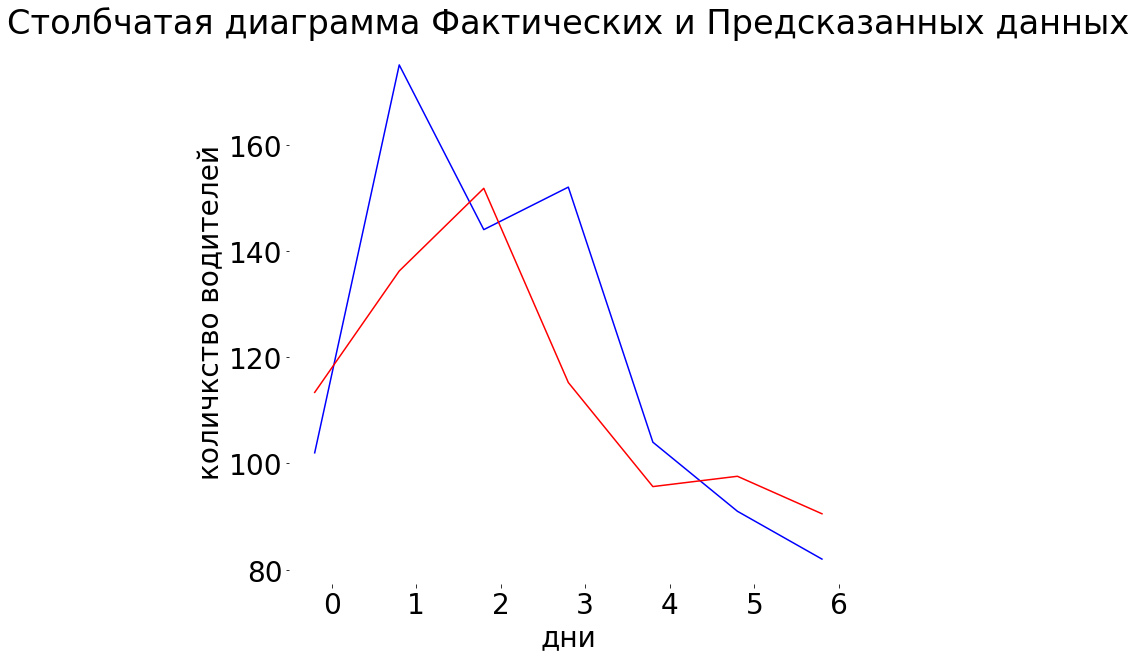

In [54]:
graph(pred[: 7],target_test[: 7])


<div  style="padding: 30px 25px; border: 5px #9966FF solid">
    
# вывод
- создали несколько моделей и протестировали их, лучшей моделью оказалась модель Linear Regression со значением RMSE на тестовой выборке: 45. На основе ее предсказаний построили график расхождения реальных и предсказанных данных, на этом графике наглядно видно, что модель крайне точно предсказывает количество водителей в определенный промежуток времени. По этому я считаю, что ее вполне можно внедрить в компанию.

</div> 